In [2]:
# === Core Libraries ===
import pandas as pd
import numpy as np

# === Sklearn / Imbalanced Learn ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost.callback import EarlyStopping


In [3]:
# === 1. Load the Dataset ===
data = pd.read_csv('migraine_symptom_classification.csv')
print("Initial shape:", data.shape)
print(data.head())


Initial shape: (400, 24)
   Age  Duration  Frequency  Location  Character  Intensity  Nausea  Vomit  \
0   30         1          5         1          1          2       1      0   
1   50         3          5         1          1          3       1      1   
2   53         2          1         1          1          2       1      1   
3   45         3          5         1          1          3       1      0   
4   53         1          1         1          1          2       1      0   

   Phonophobia  Photophobia  ...  Vertigo  Tinnitus  Hypoacusis  Diplopia  \
0            1            1  ...        0         0           0         0   
1            1            1  ...        1         0           0         0   
2            1            1  ...        0         0           0         0   
3            1            1  ...        1         0           0         0   
4            1            1  ...        0         0           0         0   

   Defect  Ataxia  Conscience  Paresthesia 

In [4]:
# === 2. Handle Categorical Columns ===
cat_cols = [
    "Location", "Character", "Intensity", "Nausea", "Vomit", "Phonophobia",
    "Photophobia", "Visual", "Sensory", "Dysphasia", "Dysarthria", "Vertigo",
    "Tinnitus", "Hypoacusis", "Diplopia", "Defect", "Ataxia", "Conscience",
    "Paresthesia", "DPF", "Type"
]
for col in cat_cols:
    data[col] = data[col].astype('category')

In [5]:
# === 3. Drop Duplicates & Check Missing Values ===
data = data.drop_duplicates()
print("After duplicate removal:", data.shape)
print("Total missing values:", data.isnull().sum().sum())

After duplicate removal: (394, 24)
Total missing values: 0


In [6]:
# === 4. Create Target Class Mapping for Type Grouping ===
new_mapping = {
    'Typical aura with migraine': 'Migraine With Typical Aura',
    'Typical aura without migraine': 'Migraine With Typical Aura',
    'Migraine without aura': 'Migraine Without Aura',
    'Familial hemiplegic migraine': 'Hemiplegic Migraine Variants',
    'Sporadic hemiplegic migraine': 'Hemiplegic Migraine Variants',
    'Basilar-type aura': 'Other Migraine Subtypes',
    'Other': 'Other Migraine Subtypes'
}

data['Type_grouped'] = data['Type'].map(new_mapping)


In [7]:
# Sanity check
print("\nType_grouped counts:")
print(data["Type_grouped"].value_counts())



Type_grouped counts:
Type_grouped
Migraine With Typical Aura      261
Migraine Without Aura            60
Hemiplegic Migraine Variants     38
Other Migraine Subtypes          35
Name: count, dtype: int64


In [8]:
# === 5. Train-Test Split (stratified on grouped target) ===
train_data, test_data = train_test_split(
    data, test_size=0.2, stratify=data['Type_grouped'], random_state=123
)


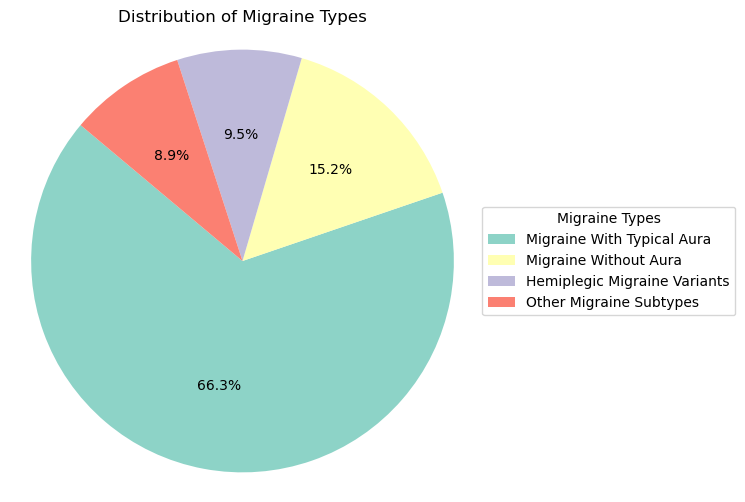

In [33]:
import matplotlib.pyplot as plt

# Get value counts for each class in training set
class_counts = train_data['Type_grouped'].value_counts()

plt.figure(figsize=(6, 6))
# No labels here; store wedge handles for legend
wedges, _, autotexts = plt.pie(
    class_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
# Add legend outside pie chart
plt.legend(wedges, class_counts.index, title="Migraine Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Distribution of Migraine Types')
plt.axis('equal')
plt.show()



In [9]:
# === 6. One-Hot Encoding ===
# Identify Categorical Columns (excluding the target)
categorical_cols = train_data.select_dtypes(include='category').columns.drop('Type')

# One-hot encode categorical variables with drop_first to reduce redundancy
train_encoded = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)

# Align features between train and test
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

In [10]:
# === 7. Encode Target Variable ===
le = LabelEncoder()
y_train = pd.Series(le.fit_transform(train_data['Type_grouped']), name='Type_grouped')
y_test = pd.Series(le.transform(test_data['Type_grouped']), name='Type_grouped')
print("\nClass Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))



Class Mapping: {'Hemiplegic Migraine Variants': 0, 'Migraine With Typical Aura': 1, 'Migraine Without Aura': 2, 'Other Migraine Subtypes': 3}


In [11]:
# === 8. Feature Matrix Preparation ===
X_train = train_encoded.drop(columns=['Type', 'Type_grouped'])
X_test = test_encoded.drop(columns=['Type', 'Type_grouped'])

# Optional: convert to int if necessary
X_train = X_train.astype(int)
X_test = X_test.astype(int)


In [12]:
# === 9. Apply SMOTE on Training Data ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [12]:
# === 10. Parameter selection of Decision Tree ===
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.005, 0.01]
}

dt = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(dt, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_resampled, y_resampled)

print("Best params:", grid.best_params_)


Best params: {'ccp_alpha': 0.0, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20}


In [13]:
# === 11. Train and Evaluate Decision Tree ===
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=5,
    max_features='log2',
    ccp_alpha=0.0,
    class_weight='balanced',
    random_state=42
)
dt_model.fit(X_resampled, y_resampled)

# Predict on test set
y_pred_test = dt_model.predict(X_test)

# Evaluation
print("\n===== DECISION TREE CLASSIFICATION REPORT (TEST SET) =====")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))


===== DECISION TREE CLASSIFICATION REPORT (TEST SET) =====
                              precision    recall  f1-score   support

Hemiplegic Migraine Variants       0.22      0.75      0.34         8
  Migraine With Typical Aura       0.97      0.56      0.71        52
       Migraine Without Aura       0.50      0.67      0.57        12
     Other Migraine Subtypes       0.83      0.71      0.77         7

                    accuracy                           0.61        79
                   macro avg       0.63      0.67      0.60        79
                weighted avg       0.81      0.61      0.66        79

Test Accuracy: 0.6075949367088608


In [14]:
# ==== 12. PREDICTIONS of Decision Tree====
y_pred_test = dt_model.predict(X_test)
y_pred_train = dt_model.predict(X_resampled)

# ==== TRAIN SET REPORT ====
print("\n===== DECISION TREE CLASSIFICATION REPORT (TRAINING SET) =====")
print(classification_report(y_resampled, y_pred_train, target_names=le.classes_))
print("Train Accuracy:", accuracy_score(y_resampled, y_pred_train))

# ==== TEST SET REPORT ====
print("\n===== DECISION TREE CLASSIFICATION REPORT (TEST SET) =====")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))



===== DECISION TREE CLASSIFICATION REPORT (TRAINING SET) =====
                              precision    recall  f1-score   support

Hemiplegic Migraine Variants       0.52      0.87      0.65       209
  Migraine With Typical Aura       0.83      0.59      0.69       209
       Migraine Without Aura       0.86      0.75      0.80       209
     Other Migraine Subtypes       0.95      0.71      0.81       209

                    accuracy                           0.73       836
                   macro avg       0.79      0.73      0.74       836
                weighted avg       0.79      0.73      0.74       836

Train Accuracy: 0.7296650717703349

===== DECISION TREE CLASSIFICATION REPORT (TEST SET) =====
                              precision    recall  f1-score   support

Hemiplegic Migraine Variants       0.22      0.75      0.34         8
  Migraine With Typical Aura       0.97      0.56      0.71        52
       Migraine Without Aura       0.50      0.67      0.57        

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For predictions: y_test (true labels), y_pred_test (model's predictions)
accuracy = accuracy_score(y_test, y_pred_test)
precision_macro = precision_score(y_test, y_pred_test, average='macro')
recall_macro = recall_score(y_test, y_pred_test, average='macro')
f1_macro = f1_score(y_test, y_pred_test, average='macro')

print("\n===== DECISION TREE CLASSIFICATION (TEST SET) =====")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision (macro): {precision_macro:.3f}")
print(f"Recall (macro): {recall_macro:.3f}")
print(f"F1 (macro): {f1_macro:.3f}")

# For predictions: y_resampled (true labels), y_pred_train (model's predictions on training data)
accuracy_train = accuracy_score(y_resampled, y_pred_train)
precision_train = precision_score(y_resampled, y_pred_train, average='macro')
recall_train = recall_score(y_resampled, y_pred_train, average='macro')
f1_train = f1_score(y_resampled, y_pred_train, average='macro')

print("\n===== DECISION TREE CLASSIFICATION (TRAIN SET) =====")
print(f"Training Accuracy: {accuracy_train:.3f}")
print(f"Training Precision (macro): {precision_train:.3f}")
print(f"Training Recall (macro): {recall_train:.3f}")
print(f"Training F1 (macro): {f1_train:.3f}")


===== DECISION TREE CLASSIFICATION (TEST SET) =====
Accuracy: 0.608
Precision (macro): 0.631
Recall (macro): 0.672
F1 (macro): 0.598

===== DECISION TREE CLASSIFICATION (TRAIN SET) =====
Training Accuracy: 0.730
Training Precision (macro): 0.790
Training Recall (macro): 0.730
Training F1 (macro): 0.738


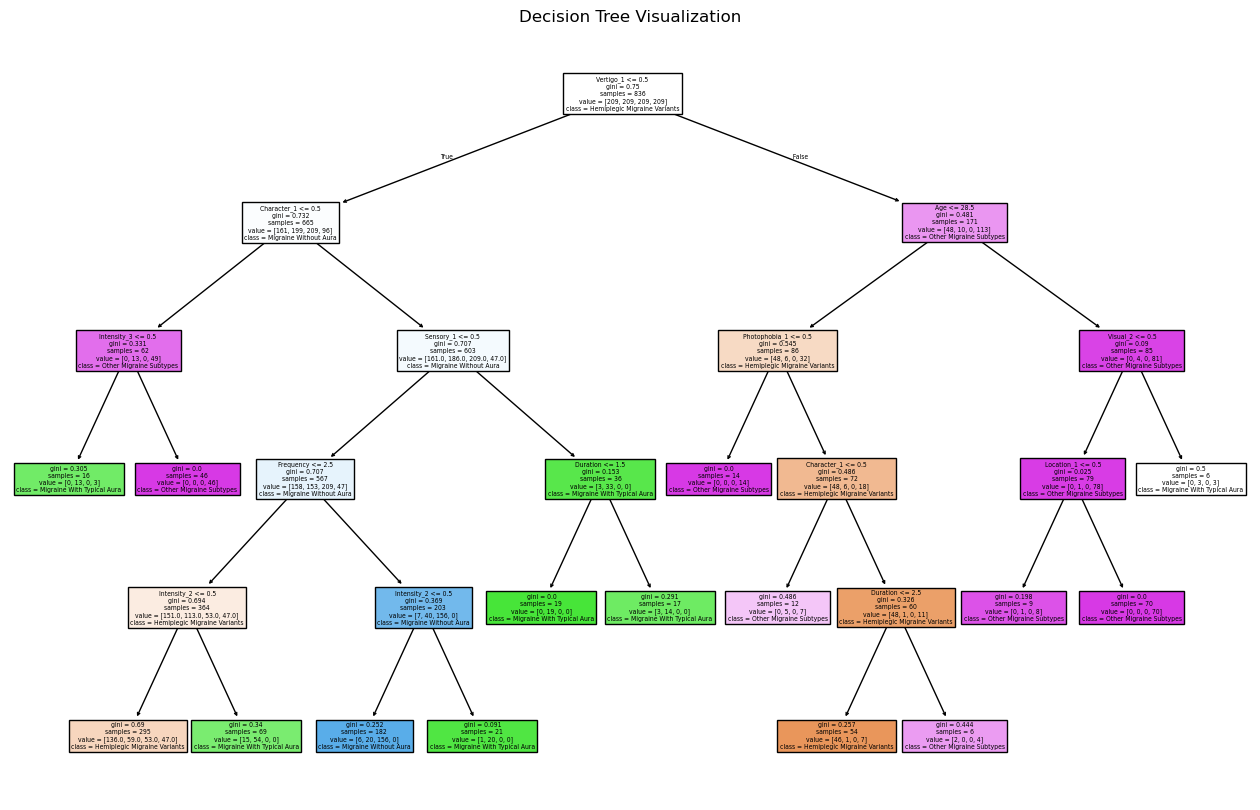

In [15]:
# === Visualization of Tree ===
plt.figure(figsize=(16, 10))
plot_tree(dt_model, filled=True, class_names=le.classes_, feature_names=X_train.columns)
plt.title("Decision Tree Visualization")
plt.show()

In [16]:
# ==== 13. Parameter selection of XGBoost Classifier ====

param_grid2 = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 1],
    'reg_lambda': [1, 2]
}

XG = XGBClassifier(random_state=42)
grid2 = GridSearchCV(XG, param_grid2, cv=5, scoring='f1_macro', n_jobs=-1)
grid2.fit(X_resampled, y_resampled)

print("Best params:", grid2.best_params_)


Best params: {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}


In [17]:
# ==== 14. Train and Evaluate XGBoost Classifier ====

xgb_model = XGBClassifier(
    max_depth=5,
    min_child_weight=1,
    subsample=0.7,
    colsample_bytree=0.8,
    n_estimators=100,
    learning_rate=0.07,
    reg_alpha=0,
    reg_lambda=1.0,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_resampled, y_resampled)


C:\Users\Vayani Kavindya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:29:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "sample_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
# ==== 15. PREDICTIONS of XGBoost Classifier ====
# Predict on test set
y_pred_test = xgb_model.predict(X_test)

# Predict on training set (SMOTE sample)
y_pred_train = xgb_model.predict(X_resampled)

# Test set evaluation
print("\n===== XGBOOST CLASSIFICATION REPORT (TEST SET) =====")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

# Training set evaluation
print("\n===== XGBOOST CLASSIFICATION REPORT (TRAINING SET) =====")
print(classification_report(y_resampled, y_pred_train, target_names=le.classes_))
print("Train Accuracy:", accuracy_score(y_resampled, y_pred_train))



===== XGBOOST CLASSIFICATION REPORT (TEST SET) =====
                              precision    recall  f1-score   support

Hemiplegic Migraine Variants       0.60      0.38      0.46         8
  Migraine With Typical Aura       0.89      0.96      0.93        52
       Migraine Without Aura       0.83      0.83      0.83        12
     Other Migraine Subtypes       0.67      0.57      0.62         7

                    accuracy                           0.85        79
                   macro avg       0.75      0.69      0.71        79
                weighted avg       0.83      0.85      0.84        79

Test Accuracy: 0.8481012658227848

===== XGBOOST CLASSIFICATION REPORT (TRAINING SET) =====
                              precision    recall  f1-score   support

Hemiplegic Migraine Variants       0.98      0.99      0.98       209
  Migraine With Typical Aura       0.99      0.97      0.98       209
       Migraine Without Aura       1.00      0.99      0.99       209
     Other

In [19]:
# ==== 16. Train and Evaluate XGBoost Classifier with early stopping====

# DMatrix for train and test
dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for XGBoost
params = {
    'objective': 'multi:softprob',
    'num_class': len(le.classes_),
    'eval_metric': 'mlogloss',
    'max_depth': 3,
    'min_child_weight': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
    'reg_alpha': 1.0,
    'reg_lambda': 10.0,
    'gamma': 1.0,
    'verbosity': 0
}


# Train model with early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtest, 'eval')],
    callbacks=[EarlyStopping(rounds=10, save_best=True)],
    verbose_eval=True
)


[0]	eval-mlogloss:1.35552
[1]	eval-mlogloss:1.33011
[2]	eval-mlogloss:1.30708
[3]	eval-mlogloss:1.28164
[4]	eval-mlogloss:1.25850
[5]	eval-mlogloss:1.23908
[6]	eval-mlogloss:1.21647
[7]	eval-mlogloss:1.19634
[8]	eval-mlogloss:1.17564
[9]	eval-mlogloss:1.16052
[10]	eval-mlogloss:1.14379
[11]	eval-mlogloss:1.12938
[12]	eval-mlogloss:1.11615
[13]	eval-mlogloss:1.10192
[14]	eval-mlogloss:1.08578
[15]	eval-mlogloss:1.07119
[16]	eval-mlogloss:1.05815
[17]	eval-mlogloss:1.04387
[18]	eval-mlogloss:1.03337
[19]	eval-mlogloss:1.02281
[20]	eval-mlogloss:1.01414
[21]	eval-mlogloss:1.00328
[22]	eval-mlogloss:0.99395
[23]	eval-mlogloss:0.98454
[24]	eval-mlogloss:0.97412
[25]	eval-mlogloss:0.96367
[26]	eval-mlogloss:0.95487
[27]	eval-mlogloss:0.94695
[28]	eval-mlogloss:0.94302
[29]	eval-mlogloss:0.93615
[30]	eval-mlogloss:0.92771
[31]	eval-mlogloss:0.92062
[32]	eval-mlogloss:0.91378
[33]	eval-mlogloss:0.90598
[34]	eval-mlogloss:0.89828
[35]	eval-mlogloss:0.88851
[36]	eval-mlogloss:0.88323
[37]	eval-m

In [20]:
# ==== 17. PREDICTIONS of XGBoost Classifier with early stopping ====

# Predictions
y_pred_test = model.predict(dtest)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

y_pred_train = model.predict(dtrain)
y_pred_train_labels = np.argmax(y_pred_train, axis=1)

# Classification Reports
print("===== XGBOOST CLASSIFICATION REPORT (TEST SET) =====")
print(classification_report(y_test, y_pred_test_labels, target_names=le.classes_))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_labels))

print("\n===== XGBOOST CLASSIFICATION REPORT (TRAINING SET) =====")
print(classification_report(y_resampled, y_pred_train_labels, target_names=le.classes_))
print("Train Accuracy:", accuracy_score(y_resampled, y_pred_train_labels))


===== XGBOOST CLASSIFICATION REPORT (TEST SET) =====
                              precision    recall  f1-score   support

Hemiplegic Migraine Variants       0.50      0.38      0.43         8
  Migraine With Typical Aura       0.89      0.94      0.92        52
       Migraine Without Aura       0.75      0.75      0.75        12
     Other Migraine Subtypes       0.67      0.57      0.62         7

                    accuracy                           0.82        79
                   macro avg       0.70      0.66      0.68        79
                weighted avg       0.81      0.82      0.81        79

Test Accuracy: 0.8227848101265823

===== XGBOOST CLASSIFICATION REPORT (TRAINING SET) =====
                              precision    recall  f1-score   support

Hemiplegic Migraine Variants       0.86      0.95      0.90       209
  Migraine With Typical Aura       0.95      0.87      0.91       209
       Migraine Without Aura       0.95      0.99      0.97       209
     Other 

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Training set metrics
accuracy_train = accuracy_score(y_resampled, y_pred_train_labels)
precision_train = precision_score(y_resampled, y_pred_train_labels, average='macro')
recall_train = recall_score(y_resampled, y_pred_train_labels, average='macro')
f1_train = f1_score(y_resampled, y_pred_train_labels, average='macro')

print("===== TRAINING SET METRICS =====")
print(f"Accuracy: {accuracy_train:.3f}")
print(f"Precision (macro): {precision_train:.3f}")
print(f"Recall (macro): {recall_train:.3f}")
print(f"F1-score (macro): {f1_train:.3f}\n")

# Test set metrics
accuracy_test = accuracy_score(y_test, y_pred_test_labels)
precision_test = precision_score(y_test, y_pred_test_labels, average='macro')
recall_test = recall_score(y_test, y_pred_test_labels, average='macro')
f1_test = f1_score(y_test, y_pred_test_labels, average='macro')

print("===== TEST SET METRICS =====")
print(f"Accuracy: {accuracy_test:.3f}")
print(f"Precision (macro): {precision_test:.3f}")
print(f"Recall (macro): {recall_test:.3f}")
print(f"F1-score (macro): {f1_test:.3f}")


===== TRAINING SET METRICS =====
Accuracy: 0.929
Precision (macro): 0.932
Recall (macro): 0.929
F1-score (macro): 0.929

===== TEST SET METRICS =====
Accuracy: 0.823
Precision (macro): 0.702
Recall (macro): 0.660
F1-score (macro): 0.677
